# **네이버 영화 리뷰**
1. BeautifulSoup을 통해 원하는 네이버 영화 리뷰 크롤링
2. 한글 리뷰 데이터 토크나이징 및 워드 클라우드 생성
---
**영화 헤어질 결심 리뷰데이터 워드 클라우드**

# 0. Import

In [ ]:
# 폰트 설치용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina' #화질 좋게 해주기")

# 1. Web Crawling

In [ ]:
!pip install bs4
!pip install lxml

In [ ]:
from bs4 import BeautifulSoup
import os
import re
import requests
import sys
import pandas as pd
from pprint import pprint

In [ ]:
# 네이버 영화 리뷰 페이지 주소
url0 = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code='
url1='&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page='

# 영화 코드
movie_num = 198413 #영화 '헤어질 결심'

# 네이버 영화 리뷰 페이지 주소(전체)
url2= url0 + str(movie_num) + url1

r0 = requests.get(url2)
html0 = r0.text
page0 = BeautifulSoup(html0, 'lxml')

""" 
(시간이 조금 오래 걸림) 전체 리뷰를 모두 가져오고 싶을 때!
# 전체 리뷰 개수
total_num = page0.select('div[class=score_total] strong[class=total] em')
total_num = total_num[0].text
total_num = total_num.replace(',','')
total_num = int(total_num)

# 전체 리뷰 페이지 개수 (한 페이지에 리뷰 10개)
total_page = total_num // 10 + 1
"""

# 리뷰 페이지 개수 설정
total_page = 100

# 영화 리뷰 데이터셋 생성
movie_review = pd.DataFrame(columns = ['score', 'review'])

# 각 리뷰 페이지에 대해 반복문 실행
for i in range(1, total_page+1):
  url = url2 + str(i)
  r = requests.get(url)
  html = r.text
  page = page = BeautifulSoup(html, 'lxml')

  # 평점 (1~10점)
  score = page.select('div[class=star_score] em')
  score = [i.text for i in score]

  # 감상평
  review = []
  for j in range(len(score)):
    map = 'div[class=score_reple] span[id=_filtered_ment_'+str(j)+']'
    review1 = page.select(map)
    review1 = review1[0].text.strip()
    review.append(review1)
    print(review)

  # 평점과 감상평을 영화 리뷰 데이터셋에 저장
  for j in range(len(score)):
    new_data = {'score': score[j], 'review': review[j]}
    movie_review = movie_review.append(new_data, ignore_index=True)

In [ ]:
movie_review[:10]

,score,review
0,10,네게 미결로 남고 싶은 내 삶의 흔적
1,10,이 영화는 4시 전후로 보는 것이 좋다. 엔딩크레딧이 올라가고 밖으로 나와 어둑해진...
2,7,"사랑에는 결심이 필요하지 않죠, 자연스러운 거니까. 그런데 헤어질 땐 결심이 필요하죠."
3,10,의심하고 미행하고 끝내 수갑 채우려 한다는 점에서 사랑은 하나의 수사극과 같다. 그...
4,10,"잠겨 죽어도 좋으니, 너는 물처럼 내게 밀려오라"
5,10,당신의 사랑이 끝났을 때나의 사랑이 시작되었고나의 사랑이 시작되었을 때당신의 사랑이...
6,10,파도처럼 밀려와 잉크처럼 번지는...
7,10,스토리 면에서 특출나게 반전인 부분이거나 새로운 느낌은 없었습니다.그러나 그 스토리...
8,10,지금 보고 나오는데 너무 좋았습니다..만추도 생각나구요..사람이 사람 좋아하면 가능...
9,7,마 . 침 . 내 .


In [ ]:
print('총 리뷰의 수 :', len(movie_review))

총 리뷰의 수 : 1000


# 2. Data Preprocessing

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

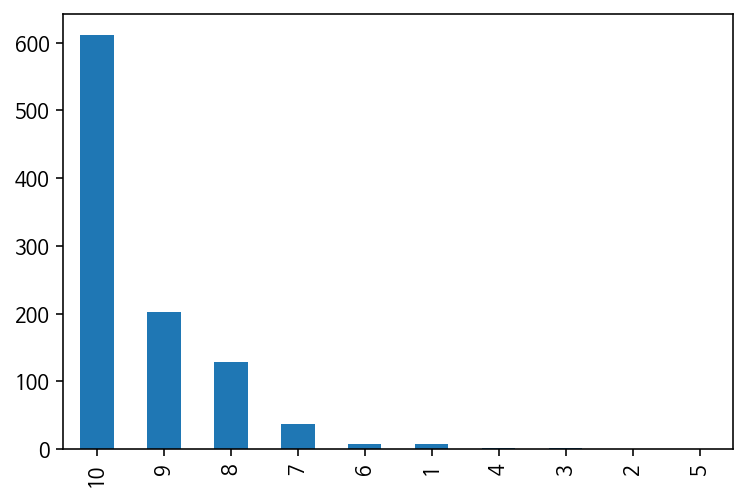

In [ ]:
# 데이터 분포 확인
movie_review['score'].value_counts().plot(kind = 'bar')

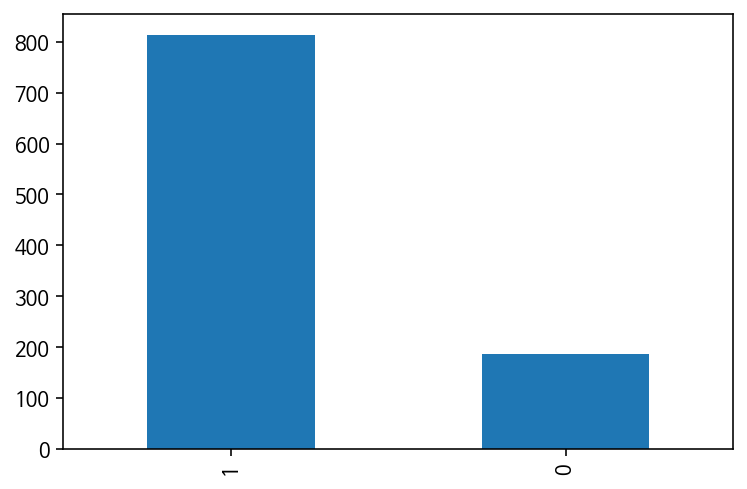

In [ ]:
# 평점이 8 초과인 경우 1, 8 이하인 경우 0으로 labeling
movie_review['score'] = movie_review['score'].astype('int')
movie_review['label'] = np.select([movie_review.score > 8], [1], default=0)
movie_review['label'].value_counts().plot(kind = 'bar')

In [ ]:
# 각 열에 대해서 중복을 제외한 샘플의 수 카운트
movie_review['score'].nunique(), movie_review['review'].nunique(), movie_review['label'].nunique()

(10, 984, 2)

In [ ]:
# review 열 중복 제거
movie_review.drop_duplicates(subset=['review'], inplace=True)
print('총 샘플의 수 :', len(movie_review))

총 샘플의 수 : 984


In [ ]:
# NA값 있는지 확인
print(movie_review.isnull().values.any())

False


**불순어 제거 및 텍스트 데이터 전처리**

In [ ]:
movie_review

,score,review,label
0,10,네게 미결로 남고 싶은 내 삶의 흔적,1
1,10,이 영화는 4시 전후로 보는 것이 좋다. 엔딩크레딧이 올라가고 밖으로 나와 어둑해진...,1
2,7,"사랑에는 결심이 필요하지 않죠, 자연스러운 거니까. 그런데 헤어질 땐 결심이 필요하죠.",0
3,10,의심하고 미행하고 끝내 수갑 채우려 한다는 점에서 사랑은 하나의 수사극과 같다. 그...,1
4,10,"잠겨 죽어도 좋으니, 너는 물처럼 내게 밀려오라",1
...,...,...,...
995,10,모든게 아름답다 마침내 박찬욱이 여기까지..,1
996,9,깐느박에 대한 나의 애정을 확인할 수 있었다. 박찬욱 감독의 영화는 박쥐가 최애였는...,1
997,8,마침내 이 영화가 내게로 왔다.,0
998,9,역시 훌륭합니다.,1


### 한국어 뛰어쓰기 교정

In [ ]:
df = movie_review
df.head()

,score,review,label
0,10,네게 미결로 남고 싶은 내 삶의 흔적,1
1,10,이 영화는 4시 전후로 보는 것이 좋다. 엔딩크레딧이 올라가고 밖으로 나와 어둑해진...,1
2,7,"사랑에는 결심이 필요하지 않죠, 자연스러운 거니까. 그런데 헤어질 땐 결심이 필요하죠.",0
3,10,의심하고 미행하고 끝내 수갑 채우려 한다는 점에서 사랑은 하나의 수사극과 같다. 그...,1
4,10,"잠겨 죽어도 좋으니, 너는 물처럼 내게 밀려오라",1


In [ ]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [ ]:
from pykospacing import Spacing
spacing = Spacing()

spaced_corpus = []
for sent in df['review']:
    spaced_corpus.append(spacing(sent))

df['text'] = spaced_corpus
df.tail(3)

,score,review,label,text
997,8,마침내 이 영화가 내게로 왔다.,0,마침내 이 영화가 내게로 왔다.
998,9,역시 훌륭합니다.,1,역시 훌륭합니다.
999,10,곱씹을수록 계속 생각나는 중독성 있는 영화예요.,1,곱씹을수록 계속 생각나는 중독성 있는 영화예요.


In [ ]:
df.iloc[746]

score                                       10
review        아 정말 너무너무 좋았습니다어눌한 한국말도결말도안개도붕괴도
label                                        1
text      아 정말 너무너무 좋았습니다 어눌한 한국말도 결말도 안개도 붕괴도
Name: 749, dtype: object

### 불용어

In [ ]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

# 불용어 설정
stopwords = ['등', '게', '걸', '줄', '알', '만', '듯', '못', '함'] # 워드 클라우드에 의미없는 단어들

df = movie_review

# 불순어 제거 (한글만 남김)
df['text'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['text'].replace('', np.nan, inplace=True)

# 결측치로 변한 행 제거
df = df.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


# 3. Word Cloud 생성

### 토크나이징 비교

**토크나이징 후 명사만 추출**


https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/

In [ ]:
from konlpy.tag import *

hannanum = Hannanum() # 한나눔
kkma = Kkma() # 꼬꼬마
komoran = Komoran() # 코모란
okt = Okt() #Okt 

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
df_sample = list(df['text'])[700]
print(df_sample)

마침내 탄생한 박찬욱표 원초지향적 멜로 클래식


In [ ]:
df_sample = list(df['text'])[700]
print(hannanum.nouns(df_sample), end = ' ')

['탄생', '박찬욱표', '원초지향적', '멜로', '클래식'] 

In [ ]:
df_sample = list(df['text'])[700]
print(kkma.nouns(df_sample), end = ' ')

['탄생', '박찬', '표', '원초', '원초지향', '지향', '멜로', '클래식'] 

In [ ]:
df_sample = list(df['text'])[700]
print(komoran.nouns(df_sample), end = ' ')

['탄생', '박찬욱', '표', '원초', '지향', '멜로', '클래식'] 

In [ ]:
df_sample = list(df['text'])[700]
print(okt.nouns(df_sample), end = ' ')

['마침내', '탄생', '박찬욱', '표', '원초', '지향', '멜로', '클래식'] 

**Okt로 토큰화**




In [ ]:
#konlpy로 명사만 추출하는 토큰화를 진행
token = []
for sentence in df['text']:
    temp_X = []
    temp_X = okt.nouns(sentence) # 명사 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    token.append(temp_X)
df['token'] = token
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token)

In [ ]:
from collections import Counter 

# 단어 빈도 수 세어서 가장 빈도 높은 300개만 추출하는 함수 정의
def tokenizing(df):
    words = np.hstack(df['token'].values)
    word_count = Counter(words)
    input = dict(word_count.most_common(300))
    return input

In [ ]:
from wordcloud import WordCloud

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(df, color):  
  df2 = tokenizing(df)
  fontpath = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
  wordcloud = WordCloud(font_path = fontpath, max_words=200, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) #빈도에 따라서 
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

**matplotlib color palette**

https://matplotlib.org/stable/tutorials/colors/colormaps.html

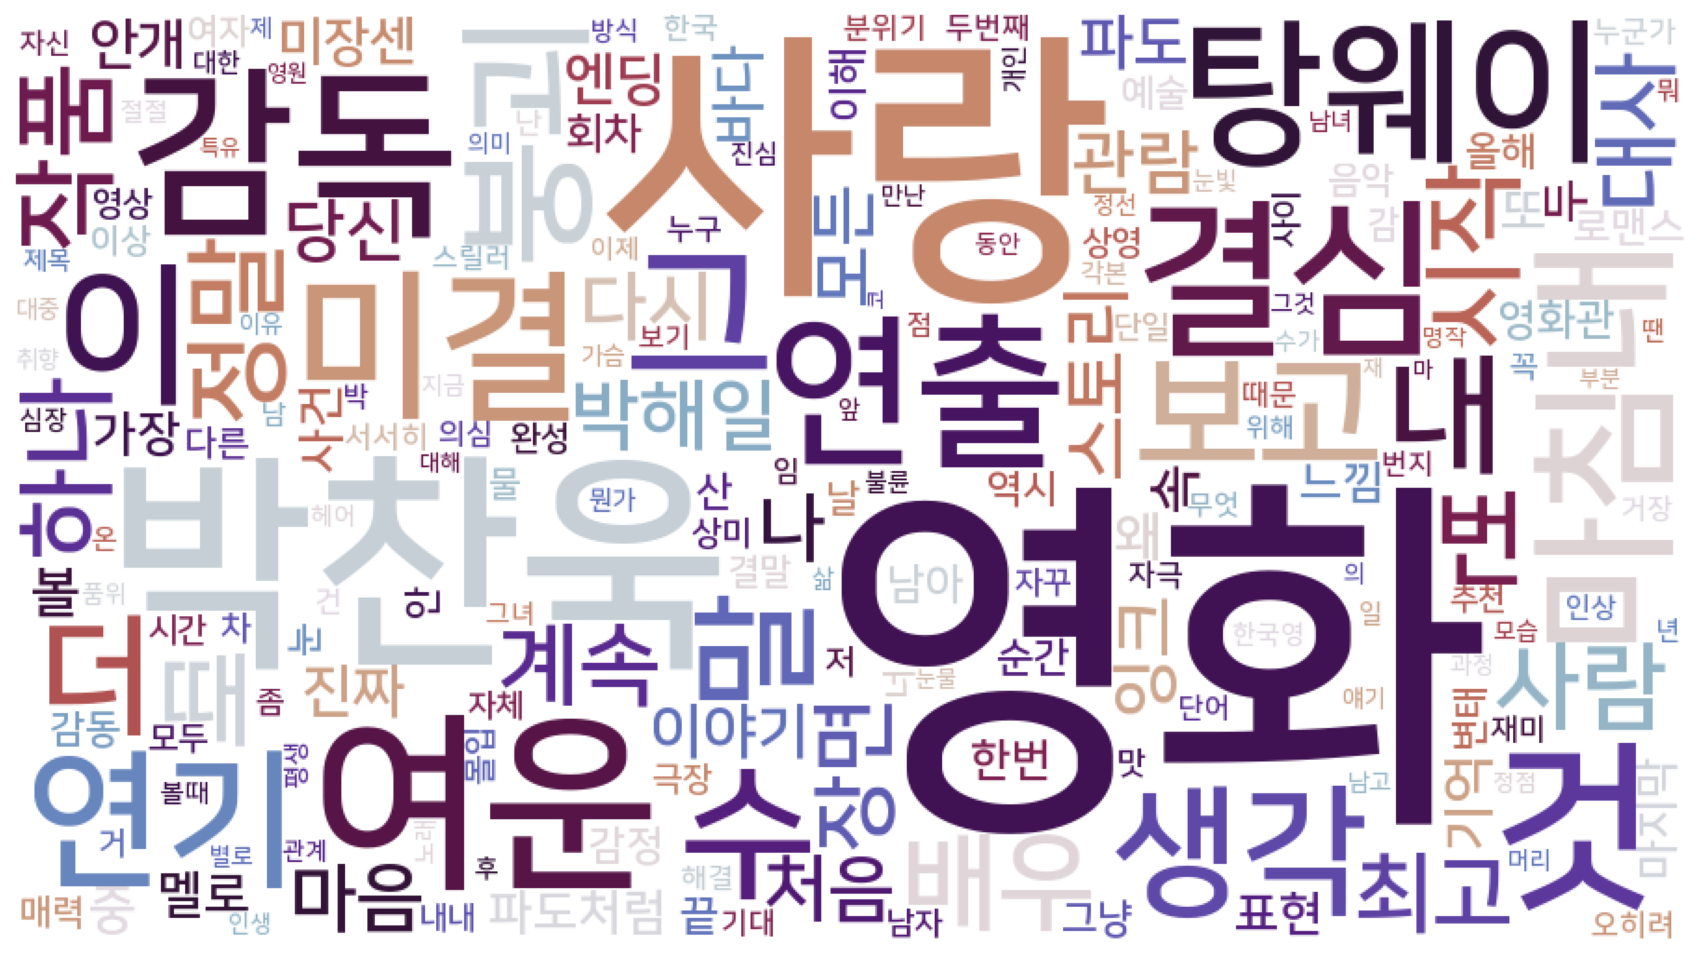

In [ ]:
wcdraw(df,'twilight_shifted')